In [1]:
import numpy as np
np.random.seed(10)
import tensorflow as tf
tf.set_random_seed(10)
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

params = {
    'text.latex.preamble': ['\\usepackage{gensymb}'],
    'image.origin': 'lower',
    'image.interpolation': 'nearest',
    'image.cmap': 'gray',
    'axes.grid': False,
    'savefig.dpi': 300,  # to adjust notebook inline plot size
    'axes.labelsize': 16, # fontsize for x and y labels (was 10)
    'axes.titlesize': 16,
    'font.size': 16, # was 10
    'legend.fontsize': 16, # was 10
    'xtick.labelsize': 16,
    'ytick.labelsize': 16,
    'text.usetex': True,
    'figure.figsize': [3.39, 2.10],
    'font.family': 'serif',
}
plt.rcParams.update(params)

In [2]:
# Generating training data that goes from initial condition location to PCA coefficient trajectory
num_modes=40
locs = np.load('../../SWE_Data/Data/Locations.npy')
pca_coeffs = np.load('../../SWE_Data/PCA_Coefficients_q1.npy')[0:num_modes,:]
coeff_scaler = MinMaxScaler()
pca_coeffs_scaled = coeff_scaler.fit_transform(np.transpose(pca_coeffs))

In [3]:
# The total shape is large due to multiple simulations
num_samples_total = np.shape(pca_coeffs_scaled)[0]
num_sims = int(num_samples_total/500)
pca_coeffs_scaled = np.reshape(pca_coeffs_scaled,newshape=(num_sims,500,40))

In [4]:
print(num_samples_total)

10000


In [5]:
state_len = np.shape(pca_coeffs_scaled)[-1]
seq_num = 20

num_samples = 500-seq_num-1
input_data = np.zeros(shape=(num_sims,seq_num,state_len+2))
output_data = np.zeros(shape=(num_sims,500-seq_num,state_len))

for simnum in range(num_sims):            
    sub_data = pca_coeffs_scaled[simnum,:,:]

    input_seq = sub_data[:seq_num,:]
    output_seq = sub_data[seq_num:,:]
    
    input_data[simnum,:,:state_len] = input_seq[None,:,:state_len]
    input_data[simnum,:,-2] = locs[simnum,0]
    input_data[simnum,:,-1] = locs[simnum,1]

    output_data[simnum,:,:] = output_seq[:]
    


# plt.figure()
# plt.plot(input_data[0,:,0])
# plt.plot(output_data[0,:,0])
# plt.show()

output_data = output_data.reshape(num_sims,(500-seq_num)*state_len,order='F')

# output_data = output_data.reshape(num_sims,480,state_len,order='F')
# plt.figure()
# plt.plot(output_data[0,:,0])
# plt.show()

In [6]:
from tensorflow.keras.layers import Input, Dense, Lambda, Add, LSTM, Dropout
from tensorflow.keras import optimizers, models, regularizers
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, Callback
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.regularizers import l1
from tensorflow.keras.utils import plot_model

In [7]:
weights_filepath = 'NA_LSTM_T.h5'

def coeff_determination(y_pred, y_true): #Order of function inputs is important here        
    SS_res =  K.sum(K.square( y_true-y_pred )) 
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) )
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

class EarlyStoppingByLossVal(Callback):
    def __init__(self, monitor='loss', value=0.00001, verbose=0):
        super(Callback, self).__init__()
        self.monitor = monitor
        self.value = value
        self.verbose = verbose

    def on_epoch_end(self, epoch, logs={}):
        current = logs.get(self.monitor)
        if current is None:
            warnings.warn("Early stopping requires %s available!" % self.monitor, RuntimeWarning)

        if current < self.value:
            if self.verbose > 0:
                print("Epoch %05d: early stopping THR" % epoch)
            self.model.stop_training = True

In [8]:
lstm_inputs = Input(shape=(seq_num,state_len+2),name='at_inputs')
h1 = LSTM(114,return_sequences=True)(lstm_inputs)
h2 = LSTM(114,return_sequences=False)(h1)
lstm_outputs = Dense(np.shape(output_data)[1],activation=None)(h2)

lstm_model = Model(inputs=lstm_inputs,outputs=lstm_outputs)

# design network
my_adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

checkpoint = ModelCheckpoint(weights_filepath, monitor='loss', verbose=1, save_best_only=True, mode='min',save_weights_only=True)
earlystopping = EarlyStopping(monitor='loss', min_delta=0, patience=100, verbose=0, mode='auto', baseline=None, restore_best_weights=False)
callbacks_list = [checkpoint,EarlyStoppingByLossVal()]

# fit network
lstm_model.compile(optimizer=my_adam,loss='mean_squared_error',metrics=[coeff_determination])    
lstm_model.summary()

W0126 18:17:24.764219 139968036169536 deprecation.py:506] From /home/rmlans/anaconda3/envs/deephyper_env/lib/python3.6/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
at_inputs (InputLayer)       [(None, 20, 42)]          0         
_________________________________________________________________
lstm (LSTM)                  (None, 20, 114)           71592     
_________________________________________________________________
lstm_1 (LSTM)                (None, 114)               104424    
_________________________________________________________________
dense (Dense)                (None, 19200)             2208000   
Total params: 2,384,016
Trainable params: 2,384,016
Non-trainable params: 0
_________________________________________________________________


In [8]:
num_epochs = 5000
batch_size = 4
train_mode = True

from time import time
start_time = time()

if train_mode:
    train_history = lstm_model.fit(x=input_data, y=output_data, epochs=num_epochs, batch_size=batch_size, callbacks=callbacks_list)
    np.save('NA_LSTM_T.npy',train_history.history['loss'])
    
end_time = time()

W0121 16:42:02.049180 140538844579648 deprecation.py:323] From /home/rmlans/anaconda3/envs/deephyper_env/lib/python3.6/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/5000
16/20 [=======================>......] - ETA: 0s - loss: 0.2578 - coeff_determination: -4253.0166
Epoch 00001: loss improved from inf to 0.25620, saving model to NAT_LSTM_TP.h5
20/20 [==============================] - 1s 39ms/sample - loss: 0.2562 - coeff_determination: -3809.8079
Epoch 2/5000
16/20 [=======================>......] - ETA: 0s - loss: 0.2121 - coeff_determination: -811.2081 
Epoch 00002: loss improved from 0.25620 to 0.20359, saving model to NAT_LSTM_TP.h5
20/20 [==============================] - 0s 6ms/sample - loss: 0.2036 - coeff_determination: -711.7150
Epoch 3/5000
12/20 [=================>............] - ETA: 0s - loss: 0.1197 - coeff_determination: -136.9476
Epoch 00003: loss improved from 0.20359 to 0.09865, saving model to NAT_LSTM_TP.h5
20/20 [==============================] - 0s 7ms/sample - loss: 0.0987 - coeff_determination: -102.3374
Epoch 4/5000
12/20 [=================>............] - ETA: 0s - loss: 0.0291 - coeff_determination: -16.7509
Epo

Epoch 63/5000
16/20 [=======================>......] - ETA: 0s - loss: 0.0089 - coeff_determination: -1.5426
Epoch 00063: loss did not improve from 0.00899
20/20 [==============================] - 0s 6ms/sample - loss: 0.0090 - coeff_determination: -1.5851
Epoch 64/5000
16/20 [=======================>......] - ETA: 0s - loss: 0.0090 - coeff_determination: -1.6684
Epoch 00064: loss did not improve from 0.00899
20/20 [==============================] - 0s 5ms/sample - loss: 0.0090 - coeff_determination: -1.6794
Epoch 65/5000
16/20 [=======================>......] - ETA: 0s - loss: 0.0091 - coeff_determination: -1.7246
Epoch 00065: loss did not improve from 0.00899
20/20 [==============================] - 0s 5ms/sample - loss: 0.0091 - coeff_determination: -1.6955
Epoch 66/5000
16/20 [=======================>......] - ETA: 0s - loss: 0.0089 - coeff_determination: -1.5532
Epoch 00066: loss did not improve from 0.00899
20/20 [==============================] - 0s 5ms/sample - loss: 0.0091 - c

Epoch 95/5000
16/20 [=======================>......] - ETA: 0s - loss: 0.0087 - coeff_determination: -1.3641
Epoch 00095: loss did not improve from 0.00899
20/20 [==============================] - 0s 5ms/sample - loss: 0.0091 - coeff_determination: -1.4559
Epoch 96/5000
16/20 [=======================>......] - ETA: 0s - loss: 0.0091 - coeff_determination: -1.5371
Epoch 00096: loss did not improve from 0.00899
20/20 [==============================] - 0s 5ms/sample - loss: 0.0091 - coeff_determination: -1.5380
Epoch 97/5000
16/20 [=======================>......] - ETA: 0s - loss: 0.0088 - coeff_determination: -1.5810
Epoch 00097: loss did not improve from 0.00899
20/20 [==============================] - 0s 6ms/sample - loss: 0.0090 - coeff_determination: -1.6480
Epoch 98/5000
12/20 [=================>............] - ETA: 0s - loss: 0.0090 - coeff_determination: -1.6526
Epoch 00098: loss did not improve from 0.00899
20/20 [==============================] - 0s 7ms/sample - loss: 0.0091 - c

Epoch 127/5000
12/20 [=================>............] - ETA: 0s - loss: 0.0087 - coeff_determination: -1.4205
Epoch 00127: loss did not improve from 0.00899
20/20 [==============================] - 0s 7ms/sample - loss: 0.0091 - coeff_determination: -1.4975
Epoch 128/5000
12/20 [=================>............] - ETA: 0s - loss: 0.0096 - coeff_determination: -1.6024
Epoch 00128: loss did not improve from 0.00899
20/20 [==============================] - 0s 7ms/sample - loss: 0.0091 - coeff_determination: -1.5002
Epoch 129/5000
12/20 [=================>............] - ETA: 0s - loss: 0.0090 - coeff_determination: -1.5301
Epoch 00129: loss did not improve from 0.00899
20/20 [==============================] - 0s 7ms/sample - loss: 0.0091 - coeff_determination: -1.5469
Epoch 130/5000
12/20 [=================>............] - ETA: 0s - loss: 0.0089 - coeff_determination: -1.5279
Epoch 00130: loss did not improve from 0.00899
20/20 [==============================] - 0s 7ms/sample - loss: 0.0091

Epoch 159/5000
12/20 [=================>............] - ETA: 0s - loss: 0.0087 - coeff_determination: -1.4477
Epoch 00159: loss did not improve from 0.00899
20/20 [==============================] - 0s 7ms/sample - loss: 0.0090 - coeff_determination: -1.5275
Epoch 160/5000
12/20 [=================>............] - ETA: 0s - loss: 0.0092 - coeff_determination: -1.5719
Epoch 00160: loss did not improve from 0.00899
20/20 [==============================] - 0s 7ms/sample - loss: 0.0090 - coeff_determination: -1.5561
Epoch 161/5000
12/20 [=================>............] - ETA: 0s - loss: 0.0089 - coeff_determination: -1.5526
Epoch 00161: loss did not improve from 0.00899
20/20 [==============================] - 0s 6ms/sample - loss: 0.0091 - coeff_determination: -1.6132
Epoch 162/5000
16/20 [=======================>......] - ETA: 0s - loss: 0.0090 - coeff_determination: -1.6211
Epoch 00162: loss did not improve from 0.00899
20/20 [==============================] - 0s 6ms/sample - loss: 0.0090

20/20 [==============================] - 0s 7ms/sample - loss: 0.0088 - coeff_determination: -1.5314
Epoch 190/5000
16/20 [=======================>......] - ETA: 0s - loss: 0.0084 - coeff_determination: -1.4546
Epoch 00190: loss improved from 0.00879 to 0.00877, saving model to NAT_LSTM_TP.h5
20/20 [==============================] - 0s 6ms/sample - loss: 0.0088 - coeff_determination: -1.5418
Epoch 191/5000
16/20 [=======================>......] - ETA: 0s - loss: 0.0088 - coeff_determination: -1.4993
Epoch 00191: loss improved from 0.00877 to 0.00875, saving model to NAT_LSTM_TP.h5
20/20 [==============================] - 0s 6ms/sample - loss: 0.0087 - coeff_determination: -1.4912
Epoch 192/5000
16/20 [=======================>......] - ETA: 0s - loss: 0.0087 - coeff_determination: -1.5402
Epoch 00192: loss improved from 0.00875 to 0.00873, saving model to NAT_LSTM_TP.h5
20/20 [==============================] - 0s 6ms/sample - loss: 0.0087 - coeff_determination: -1.5524
Epoch 193/5000
16

Epoch 248/5000
12/20 [=================>............] - ETA: 0s - loss: 0.0065 - coeff_determination: -0.1638
Epoch 00248: loss did not improve from 0.00621
20/20 [==============================] - 0s 7ms/sample - loss: 0.0062 - coeff_determination: -0.1363
Epoch 249/5000
12/20 [=================>............] - ETA: 0s - loss: 0.0058 - coeff_determination: -0.0358
Epoch 00249: loss improved from 0.00621 to 0.00611, saving model to NAT_LSTM_TP.h5
20/20 [==============================] - 0s 8ms/sample - loss: 0.0061 - coeff_determination: -0.0681
Epoch 250/5000
12/20 [=================>............] - ETA: 0s - loss: 0.0063 - coeff_determination: -0.1336
Epoch 00250: loss improved from 0.00611 to 0.00604, saving model to NAT_LSTM_TP.h5
20/20 [==============================] - 0s 8ms/sample - loss: 0.0060 - coeff_determination: -0.0513
Epoch 251/5000
12/20 [=================>............] - ETA: 0s - loss: 0.0055 - coeff_determination: 0.0449
Epoch 00251: loss improved from 0.00604 to 0.

12/20 [=================>............] - ETA: 0s - loss: 0.0044 - coeff_determination: 0.3687
Epoch 00307: loss did not improve from 0.00450
20/20 [==============================] - 0s 7ms/sample - loss: 0.0045 - coeff_determination: 0.3845
Epoch 308/5000
12/20 [=================>............] - ETA: 0s - loss: 0.0042 - coeff_determination: 0.4500
Epoch 00308: loss improved from 0.00450 to 0.00441, saving model to NAT_LSTM_TP.h5
20/20 [==============================] - 0s 8ms/sample - loss: 0.0044 - coeff_determination: 0.4279
Epoch 309/5000
12/20 [=================>............] - ETA: 0s - loss: 0.0044 - coeff_determination: 0.3819
Epoch 00309: loss improved from 0.00441 to 0.00436, saving model to NAT_LSTM_TP.h5
20/20 [==============================] - 0s 8ms/sample - loss: 0.0044 - coeff_determination: 0.4267
Epoch 310/5000
12/20 [=================>............] - ETA: 0s - loss: 0.0044 - coeff_determination: 0.4007
Epoch 00310: loss improved from 0.00436 to 0.00435, saving model t

Epoch 337/5000
12/20 [=================>............] - ETA: 0s - loss: 0.0032 - coeff_determination: 0.6225
Epoch 00337: loss improved from 0.00349 to 0.00348, saving model to NAT_LSTM_TP.h5
20/20 [==============================] - 0s 8ms/sample - loss: 0.0035 - coeff_determination: 0.5953
Epoch 338/5000
12/20 [=================>............] - ETA: 0s - loss: 0.0035 - coeff_determination: 0.5918
Epoch 00338: loss did not improve from 0.00348
20/20 [==============================] - 0s 7ms/sample - loss: 0.0035 - coeff_determination: 0.5967
Epoch 339/5000
12/20 [=================>............] - ETA: 0s - loss: 0.0038 - coeff_determination: 0.5523
Epoch 00339: loss improved from 0.00348 to 0.00344, saving model to NAT_LSTM_TP.h5
20/20 [==============================] - 0s 8ms/sample - loss: 0.0034 - coeff_determination: 0.5978
Epoch 340/5000
12/20 [=================>............] - ETA: 0s - loss: 0.0036 - coeff_determination: 0.5581
Epoch 00340: loss improved from 0.00344 to 0.00341,

12/20 [=================>............] - ETA: 0s - loss: 0.0029 - coeff_determination: 0.6837
Epoch 00366: loss improved from 0.00271 to 0.00268, saving model to NAT_LSTM_TP.h5
20/20 [==============================] - 0s 8ms/sample - loss: 0.0027 - coeff_determination: 0.7057
Epoch 367/5000
12/20 [=================>............] - ETA: 0s - loss: 0.0030 - coeff_determination: 0.6573
Epoch 00367: loss did not improve from 0.00268
20/20 [==============================] - 0s 7ms/sample - loss: 0.0027 - coeff_determination: 0.6958
Epoch 368/5000
12/20 [=================>............] - ETA: 0s - loss: 0.0026 - coeff_determination: 0.7219
Epoch 00368: loss improved from 0.00268 to 0.00268, saving model to NAT_LSTM_TP.h5
20/20 [==============================] - 0s 7ms/sample - loss: 0.0027 - coeff_determination: 0.7113
Epoch 369/5000
12/20 [=================>............] - ETA: 0s - loss: 0.0025 - coeff_determination: 0.7260
Epoch 00369: loss improved from 0.00268 to 0.00263, saving model t

Epoch 395/5000
12/20 [=================>............] - ETA: 0s - loss: 0.0019 - coeff_determination: 0.8047
Epoch 00395: loss did not improve from 0.00190
20/20 [==============================] - 0s 7ms/sample - loss: 0.0019 - coeff_determination: 0.8073
Epoch 396/5000
12/20 [=================>............] - ETA: 0s - loss: 0.0020 - coeff_determination: 0.8050
Epoch 00396: loss did not improve from 0.00190
20/20 [==============================] - 0s 7ms/sample - loss: 0.0019 - coeff_determination: 0.8082
Epoch 397/5000
12/20 [=================>............] - ETA: 0s - loss: 0.0020 - coeff_determination: 0.8144
Epoch 00397: loss did not improve from 0.00190
20/20 [==============================] - 0s 6ms/sample - loss: 0.0020 - coeff_determination: 0.8063
Epoch 398/5000
12/20 [=================>............] - ETA: 0s - loss: 0.0020 - coeff_determination: 0.8145
Epoch 00398: loss improved from 0.00190 to 0.00188, saving model to NAT_LSTM_TP.h5
20/20 [==============================] -

Epoch 424/5000
12/20 [=================>............] - ETA: 0s - loss: 0.0014 - coeff_determination: 0.8666
Epoch 00424: loss improved from 0.00151 to 0.00150, saving model to NAT_LSTM_TP.h5
20/20 [==============================] - 0s 8ms/sample - loss: 0.0015 - coeff_determination: 0.8555
Epoch 425/5000
12/20 [=================>............] - ETA: 0s - loss: 0.0015 - coeff_determination: 0.8618
Epoch 00425: loss improved from 0.00150 to 0.00148, saving model to NAT_LSTM_TP.h5
20/20 [==============================] - 0s 7ms/sample - loss: 0.0015 - coeff_determination: 0.8566
Epoch 426/5000
12/20 [=================>............] - ETA: 0s - loss: 0.0016 - coeff_determination: 0.8492
Epoch 00426: loss improved from 0.00148 to 0.00147, saving model to NAT_LSTM_TP.h5
20/20 [==============================] - 0s 7ms/sample - loss: 0.0015 - coeff_determination: 0.8577
Epoch 427/5000
12/20 [=================>............] - ETA: 0s - loss: 0.0015 - coeff_determination: 0.8633
Epoch 00427: lo

12/20 [=================>............] - ETA: 0s - loss: 9.9202e-04 - coeff_determination: 0.9064
Epoch 00453: loss improved from 0.00109 to 0.00105, saving model to NAT_LSTM_TP.h5
20/20 [==============================] - 0s 7ms/sample - loss: 0.0011 - coeff_determination: 0.9027
Epoch 454/5000
12/20 [=================>............] - ETA: 0s - loss: 0.0011 - coeff_determination: 0.9021    
Epoch 00454: loss improved from 0.00105 to 0.00104, saving model to NAT_LSTM_TP.h5
20/20 [==============================] - 0s 7ms/sample - loss: 0.0010 - coeff_determination: 0.9050
Epoch 455/5000
16/20 [=======================>......] - ETA: 0s - loss: 0.0011 - coeff_determination: 0.9014
Epoch 00455: loss improved from 0.00104 to 0.00102, saving model to NAT_LSTM_TP.h5
20/20 [==============================] - 0s 7ms/sample - loss: 0.0010 - coeff_determination: 0.9047
Epoch 456/5000
12/20 [=================>............] - ETA: 0s - loss: 9.7079e-04 - coeff_determination: 0.9143
Epoch 00456: loss 

12/20 [=================>............] - ETA: 0s - loss: 0.0012 - coeff_determination: 0.8919
Epoch 00512: loss did not improve from 0.00061
20/20 [==============================] - 0s 7ms/sample - loss: 0.0015 - coeff_determination: 0.8437
Epoch 513/5000
12/20 [=================>............] - ETA: 0s - loss: 0.0017 - coeff_determination: 0.8389
Epoch 00513: loss did not improve from 0.00061
20/20 [==============================] - 0s 7ms/sample - loss: 0.0017 - coeff_determination: 0.8351
Epoch 514/5000
12/20 [=================>............] - ETA: 0s - loss: 0.0017 - coeff_determination: 0.8284
Epoch 00514: loss did not improve from 0.00061
20/20 [==============================] - 0s 7ms/sample - loss: 0.0017 - coeff_determination: 0.8350
Epoch 515/5000
12/20 [=================>............] - ETA: 0s - loss: 0.0016 - coeff_determination: 0.8465
Epoch 00515: loss did not improve from 0.00061
20/20 [==============================] - 0s 7ms/sample - loss: 0.0017 - coeff_determination

Epoch 544/5000
12/20 [=================>............] - ETA: 0s - loss: 7.4145e-04 - coeff_determination: 0.9350
Epoch 00544: loss did not improve from 0.00061
20/20 [==============================] - 0s 7ms/sample - loss: 6.7792e-04 - coeff_determination: 0.9404
Epoch 545/5000
12/20 [=================>............] - ETA: 0s - loss: 7.0057e-04 - coeff_determination: 0.9384
Epoch 00545: loss did not improve from 0.00061
20/20 [==============================] - 0s 7ms/sample - loss: 6.7918e-04 - coeff_determination: 0.9409
Epoch 546/5000
12/20 [=================>............] - ETA: 0s - loss: 6.4405e-04 - coeff_determination: 0.9443
Epoch 00546: loss did not improve from 0.00061
20/20 [==============================] - 0s 7ms/sample - loss: 6.6872e-04 - coeff_determination: 0.9415
Epoch 547/5000
12/20 [=================>............] - ETA: 0s - loss: 7.7670e-04 - coeff_determination: 0.9329
Epoch 00547: loss did not improve from 0.00061
20/20 [==============================] - 0s 7ms/

Epoch 573/5000
12/20 [=================>............] - ETA: 0s - loss: 3.2452e-04 - coeff_determination: 0.9731
Epoch 00573: loss did not improve from 0.00039
20/20 [==============================] - 0s 7ms/sample - loss: 3.9174e-04 - coeff_determination: 0.9669
Epoch 574/5000
12/20 [=================>............] - ETA: 0s - loss: 3.1001e-04 - coeff_determination: 0.9734
Epoch 00574: loss did not improve from 0.00039
20/20 [==============================] - 0s 7ms/sample - loss: 3.9384e-04 - coeff_determination: 0.9660
Epoch 575/5000
12/20 [=================>............] - ETA: 0s - loss: 3.9374e-04 - coeff_determination: 0.9676
Epoch 00575: loss did not improve from 0.00039
20/20 [==============================] - 0s 7ms/sample - loss: 4.4098e-04 - coeff_determination: 0.9624
Epoch 576/5000
12/20 [=================>............] - ETA: 0s - loss: 3.7517e-04 - coeff_determination: 0.9669
Epoch 00576: loss did not improve from 0.00039
20/20 [==============================] - 0s 7ms/

Epoch 602/5000
12/20 [=================>............] - ETA: 0s - loss: 2.8306e-04 - coeff_determination: 0.9752
Epoch 00602: loss improved from 0.00024 to 0.00023, saving model to NAT_LSTM_TP.h5
20/20 [==============================] - 0s 8ms/sample - loss: 2.3245e-04 - coeff_determination: 0.9802
Epoch 603/5000
12/20 [=================>............] - ETA: 0s - loss: 1.8694e-04 - coeff_determination: 0.9850
Epoch 00603: loss improved from 0.00023 to 0.00023, saving model to NAT_LSTM_TP.h5
20/20 [==============================] - 0s 8ms/sample - loss: 2.3115e-04 - coeff_determination: 0.9808
Epoch 604/5000
12/20 [=================>............] - ETA: 0s - loss: 2.1415e-04 - coeff_determination: 0.9822
Epoch 00604: loss improved from 0.00023 to 0.00023, saving model to NAT_LSTM_TP.h5
20/20 [==============================] - 0s 8ms/sample - loss: 2.2574e-04 - coeff_determination: 0.9811
Epoch 605/5000
12/20 [=================>............] - ETA: 0s - loss: 1.6107e-04 - coeff_determina

Epoch 631/5000
12/20 [=================>............] - ETA: 0s - loss: 2.4431e-04 - coeff_determination: 0.9784
Epoch 00631: loss did not improve from 0.00016
20/20 [==============================] - 0s 7ms/sample - loss: 1.8039e-04 - coeff_determination: 0.9843
Epoch 632/5000
12/20 [=================>............] - ETA: 0s - loss: 1.8953e-04 - coeff_determination: 0.9850
Epoch 00632: loss did not improve from 0.00016
20/20 [==============================] - 0s 7ms/sample - loss: 1.8830e-04 - coeff_determination: 0.9845
Epoch 633/5000
12/20 [=================>............] - ETA: 0s - loss: 1.7496e-04 - coeff_determination: 0.9860
Epoch 00633: loss did not improve from 0.00016
20/20 [==============================] - 0s 7ms/sample - loss: 1.9864e-04 - coeff_determination: 0.9830
Epoch 634/5000
12/20 [=================>............] - ETA: 0s - loss: 2.6271e-04 - coeff_determination: 0.9783
Epoch 00634: loss did not improve from 0.00016
20/20 [==============================] - 0s 8ms/

Epoch 660/5000
12/20 [=================>............] - ETA: 0s - loss: 8.0058e-05 - coeff_determination: 0.9937
Epoch 00660: loss improved from 0.00009 to 0.00009, saving model to NAT_LSTM_TP.h5
20/20 [==============================] - 0s 7ms/sample - loss: 8.5242e-05 - coeff_determination: 0.9932
Epoch 661/5000
12/20 [=================>............] - ETA: 0s - loss: 7.3147e-05 - coeff_determination: 0.9942
Epoch 00661: loss improved from 0.00009 to 0.00008, saving model to NAT_LSTM_TP.h5
20/20 [==============================] - 0s 8ms/sample - loss: 8.3874e-05 - coeff_determination: 0.9929
Epoch 662/5000
12/20 [=================>............] - ETA: 0s - loss: 6.3577e-05 - coeff_determination: 0.9949
Epoch 00662: loss improved from 0.00008 to 0.00008, saving model to NAT_LSTM_TP.h5
20/20 [==============================] - 0s 8ms/sample - loss: 7.9819e-05 - coeff_determination: 0.9934
Epoch 663/5000
12/20 [=================>............] - ETA: 0s - loss: 1.0661e-04 - coeff_determina

Epoch 719/5000
12/20 [=================>............] - ETA: 0s - loss: 3.7837e-05 - coeff_determination: 0.9968
Epoch 00719: loss improved from 0.00003 to 0.00003, saving model to NAT_LSTM_TP.h5
20/20 [==============================] - 0s 7ms/sample - loss: 2.9817e-05 - coeff_determination: 0.9975
Epoch 720/5000
12/20 [=================>............] - ETA: 0s - loss: 2.0122e-05 - coeff_determination: 0.9984
Epoch 00720: loss improved from 0.00003 to 0.00003, saving model to NAT_LSTM_TP.h5
20/20 [==============================] - 0s 8ms/sample - loss: 2.6039e-05 - coeff_determination: 0.9979
Epoch 721/5000
12/20 [=================>............] - ETA: 0s - loss: 3.2384e-05 - coeff_determination: 0.9973
Epoch 00721: loss improved from 0.00003 to 0.00002, saving model to NAT_LSTM_TP.h5
20/20 [==============================] - 0s 8ms/sample - loss: 2.4990e-05 - coeff_determination: 0.9980
Epoch 722/5000
12/20 [=================>............] - ETA: 0s - loss: 2.9600e-05 - coeff_determina

Epoch 749/5000
12/20 [=================>............] - ETA: 0s - loss: 8.9154e-06 - coeff_determination: 0.9993
Epoch 00749: loss improved from 0.00001 to 0.00001, saving model to NAT_LSTM_TP.h5
20/20 [==============================] - 0s 8ms/sample - loss: 9.8804e-06 - coeff_determination: 0.9992


In [9]:
print('Time elapsed is:',end_time-start_time)

Time elapsed is: 109.77110266685486


In [11]:
# Testing
import matplotlib.pyplot as plt
# Load model weights first
lstm_model.load_weights(weights_filepath)

filename = '../../SWE_Data/Data/snapshot_matrix_pod_test.npy'
test_data = np.load(filename)[0:64*64,:]
pca_vectors = np.load('../../SWE_Data/PCA_Vectors_q1.npy')[:,:num_modes]

true_pca_evol = coeff_scaler.transform(np.matmul(np.transpose(test_data),pca_vectors))
test_data = np.zeros(shape=(500,num_modes+2))
test_data[:,:num_modes] = true_pca_evol[:,:]

test_data[:,-2] = -1.0/2.7
test_data[:,-1] = -1.0/4.0

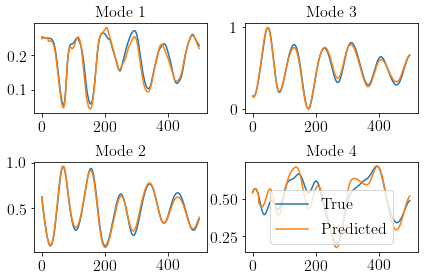

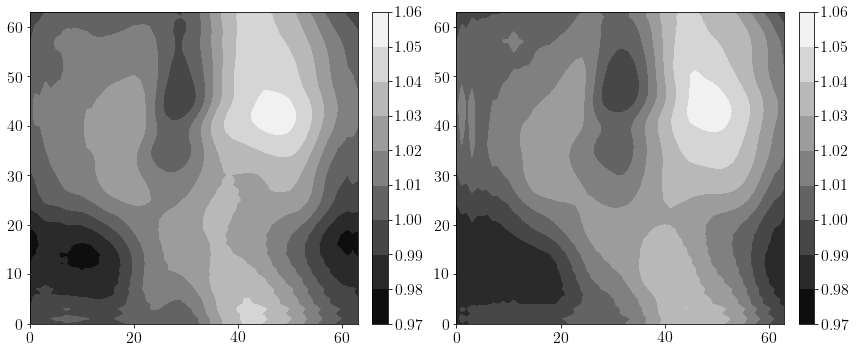

In [13]:
testing_inputs = np.copy(test_data[:seq_num,:]).reshape(1,seq_num,state_len+2,order='F')
true_outputs = np.copy(test_data[seq_num:,:state_len]).reshape(1,500-seq_num,state_len,order='F')
predicted_outputs = lstm_model.predict(testing_inputs).reshape(1,500-seq_num,state_len,order='F')

true_plot_array = np.concatenate((testing_inputs[:,:,:state_len],true_outputs),axis=1)
pred_plot_array = np.concatenate((testing_inputs[:,:,:state_len],predicted_outputs),axis=1)

fig,ax = plt.subplots(nrows=2,ncols=2)
ax[0,0].plot(true_plot_array[0,:,0],label='True')
ax[0,0].plot(pred_plot_array[0,:,0],label='Predicted')
ax[0,0].set_title('Mode 1')


ax[1,0].plot(true_plot_array[0,:,1],label='True')
ax[1,0].plot(pred_plot_array[0,:,1],label='Predicted')
ax[1,0].set_title('Mode 2')

ax[0,1].plot(true_plot_array[0,:,2],label='True')
ax[0,1].plot(pred_plot_array[0,:,2],label='Predicted')
ax[0,1].set_title('Mode 3')

ax[1,1].plot(true_plot_array[0,:,3],label='True')
ax[1,1].plot(pred_plot_array[0,:,3],label='Predicted')
ax[1,1].set_title('Mode 4')

plt.tight_layout()
plt.legend()
plt.show()

np.save('../Figures/NA_LSTM_T_Preds.npy',pred_plot_array)

# Plotting some contours
# True field
true_rb = np.transpose(coeff_scaler.inverse_transform(true_pca_evol))
true_recon = np.matmul(pca_vectors,true_rb)[:,-1].reshape(64,64)

pred_rb = pred_plot_array[0,:,:]
pred_rb = np.transpose(coeff_scaler.inverse_transform(pred_rb))
pred_recon = np.matmul(pca_vectors,pred_rb)[:,-1].reshape(64,64)


fig,ax = plt.subplots(nrows=1,ncols=2,figsize=(12,5))
cx = ax[0].contourf(true_recon)
ax[1].contourf(pred_recon)

fig.colorbar(cx,ax=ax[0],fraction=0.046, pad=0.04)
fig.colorbar(cx,ax=ax[1],fraction=0.046, pad=0.04)
plt.tight_layout()
plt.show()

np.save('../Figures/NA_LSTM_T_Fields.npy',pred_recon)